## Aim to predict cuisine from ingredients.
#### Method:
- Tfidf-vectorized ingredients and fit Ridge regression to achieve 75% accuracy on both train&test data

#### Findings:
- <font color='red'>Mis-classification</font> occured frequently at cuisines sharing historical origins, e.g. (vietnamese, thai and chinese) or (brazilian and spanish).

- Would recommend combining cuisine categories for those mentioned above to improve predictability.

#### Recommendations for future manual labeling:
- top 5 most frequent unigrams (single words) were listed in the end
- people could refer to top words to speed up labeling
- ranking was done by taking mean of tf * idf within each class and sorting
- because Ridge regression coefficients were split when two features are correlated, thus not used for importance.

### Description:

"Would be helpful to combine some categories in response to the above situation.
You've just joined the data team at an online publishing company. One of your verticals is a food publication. A product manager on your team wants to build a feature for this vertical that enables users to query by cuisine, not just by ingredients. Most of your recipes are unlabeled, and it's infeasible to label them by hand. Luckily, you have a small training set of about 10,000 recipes with labeled cuisines. 

Design and execute a method to predict the cuisine of a recipe given only its ingredients. How could you design this to be robust enough to understand similarities / substitutions between ingredients? For each each major cuisine, what are the driving ingredients that characterize it?

Your product manager indicates a likelihood that you will only need to write a guideline for an outsourced team to hand label the remaining corpus. How would you go about writing this guide for a few major cuisines?"

In [1]:
import os
import json
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
home = os.getcwd()
dir = os.path.dirname(home) #"data_challenge_6" folder

In [2]:
# create a class representing a recipe
# credit to: https://www.makeuseof.com/tag/json-python-parsing-simple-guide/
class Recipe:
    def __init__(self, rid, cuisine, ingredients):
        self.rid = rid
        self.cuisine = cuisine
        self.ingredients = ingredients
        
    # define how Recipe is printed
    def __str__(self):
        return '{{"rid" = "{0}","cuisine" = "{1}", "ingredients" = {2}}}'.format(self.rid, self.cuisine, self.ingredients)

# define an object_hook function
def obj_creator(d):
    return Recipe(d['id'], d['cuisine'], d['ingredients'])

# read and parse json 
with open(os.path.join(dir,r'recipies.json'), 'r') as fp:
    obj = json.load(fp, object_hook = obj_creator)

In [3]:
print(obj[0])

{"rid" = "10259","cuisine" = "greek", "ingredients" = ['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese crumbles']}


In [4]:
rid = [obj[x].rid for x in range(len(obj))]
cuisine = [obj[x].cuisine for x in range(len(obj))]

# flatten nested list of ingredients
ingredient = [ing for x in range(len(obj)) for ing in obj[x].ingredients]

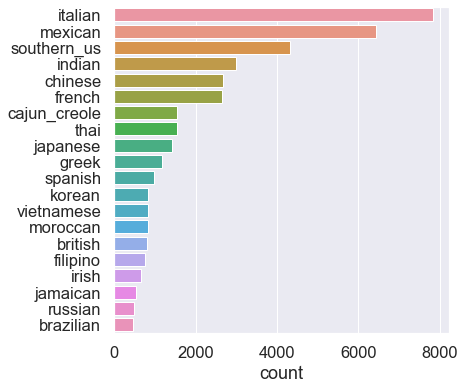

In [5]:
# Count labeled cuisines
sns.set(font_scale=1)
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(6,6)})
sns.set_context("notebook", font_scale=1.5)
ax = sns.countplot(y=cuisine, order = pd.Series(cuisine).value_counts().index.tolist())

In [6]:
# Count ingredients
print("There are {0} ingredients for {2} recipies, where {1} ingredients are unique.".format(len(ingredient), len(set(ingredient)),len(set(rid))))

# Print most common ingredients
print("="*5 + "Most Common:" + "="*5)
fdist = nltk.FreqDist(ingredient)
for word, frequency in fdist.most_common(50):
    print(u'{};{}'.format(word, frequency)) 

There are 428275 ingredients for 39774 recipies, where 6714 ingredients are unique.
=====Most Common:=====
salt;18049
onions;7972
olive oil;7972
water;7457
garlic;7380
sugar;6434
garlic cloves;6237
butter;4848
ground black pepper;4785
all-purpose flour;4632
pepper;4438
vegetable oil;4385
eggs;3388
soy sauce;3296
kosher salt;3113
green onions;3078
tomatoes;3058
large eggs;2948
carrots;2814
unsalted butter;2782
ground cumin;2747
extra-virgin olive oil;2747
black pepper;2627
milk;2263
chili powder;2036
oil;1970
red bell pepper;1939
purple onion;1896
scallions;1891
grated parmesan cheese;1886
sesame oil;1773
corn starch;1757
ginger;1755
baking powder;1738
jalapeno chilies;1730
dried oregano;1707
chopped cilantro fresh;1698
fresh lemon juice;1679
diced tomatoes;1624
fresh parsley;1604
minced garlic;1583
chicken broth;1554
sour cream;1539
cayenne pepper;1523
fresh ginger;1503
brown sugar;1503
cooking spray;1490
shallots;1477
garlic powder;1442
lime;1439


- saw common words such as all-purpose, salt and large.

In [7]:
# check the number of words in ingredients
unique_ing = list(set(ingredient))

# count number of unigrams in unique ingredients
ulength = [string.rstrip().count(" ")+1 for string in unique_ing]

# count number of unigrams in all ingredients
alength = [string.rstrip().count(" ")+1 for string in ingredient]

print(pd.Series(alength).value_counts())
print(pd.Series(ulength).value_counts())

2     214333
1     139246
3      62903
4       8981
5       1822
6        844
7         99
9         24
8         17
11         3
10         3
dtype: int64
2     3161
3     1542
1     1175
4      516
5      169
6       89
7       35
8       13
9       10
11       2
10       2
dtype: int64


In [9]:
# check to see what long ingredients (>9 unigrams) look like
from itertools import compress
list(compress(unique_ing, [x>9 for x in ulength]))

['2 1/2 to 3 lb. chicken, cut into serving pieces',
 'KRAFT Mexican Style Shredded Four Cheese with a TOUCH OF PHILADELPHIA',
 'KRAFT Shredded Pepper Jack Cheese with a TOUCH OF PHILADELPHIA',
 "i can't believ it' not butter! made with olive oil spread"]

- The majority of tokens are less than 5-grams

In [10]:
# Tokenize data
# Reference: https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_validate,StratifiedKFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scipy import sparse

# sklearn modules for performance metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve, recall_score, log_loss
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import average_precision_score

In [11]:
# make nested lists for ingredients
ll_ingredient = [obj[x].ingredients for x in range(len(obj))]

# convert sublist into a string
str_ingr = [' '.join(x) for x in ll_ingredient]

In [12]:
# initialize Tfidf vectorizer
vectorizer = TfidfVectorizer()

# fit and transform
X = vectorizer.fit_transform(str_ingr)

# split train-test, response is cuisine
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    cuisine,
                                                    test_size=0.20,
                                                    random_state=7,
                                                    stratify=cuisine)  
print("X_train dataset: ", X_train.shape)
print("y_train dataset: ", len(y_train))
print("X_test dataset: ", X_test.shape)
print("y_test dataset: ", len(y_test))

X_train dataset:  (31819, 3010)
y_train dataset:  31819
X_test dataset:  (7955, 3010)
y_test dataset:  7955


In [94]:
models = []

# use default "lbfgs" solver to deal with larger dataset and multinomial loss
# use default "L2" regularization
models.append(('Ridge LR', LogisticRegression(solver='lbfgs',random_state=7,max_iter=1000,
                                              class_weight='balanced', multi_class = 'auto'))) 
models.append(('MultinomialNaiveBayes', MultinomialNB()))
models.append(('Random Forest', RandomForestClassifier(n_estimators=100, random_state=7)))
models.append(('XGB',XGBClassifier(objective="multi:softprob", random_state=7)))

In [95]:
acc_results = []
f1_results = []
names = []
# set table to table to populate with performance results
col = ['Algorithm','Accuracy Mean', 'Accuracy STD', 'F1 Mean', 'F1 STD']
df_results = pd.DataFrame(columns=col)
i = 0

In [96]:
# evaluate each model using cross-validation
for name, model in models:
    # 10-fold cross-validation
    kfold = StratifiedKFold(n_splits=10, random_state=7) 

    # accuracy scoring
    cv_acc_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    
    # f1 scoring
    cv_f1_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1_weighted')

    acc_results.append(cv_acc_results)
    f1_results.append(cv_f1_results)
    names.append(name)
    df_results.loc[i] = [name,
                         round(cv_acc_results.mean()*100, 2),
                         round(cv_acc_results.std()*100, 2),
                         round(cv_f1_results.mean()*100, 2),
                         round(cv_f1_results.std()*100, 2)
                         ]
    i += 1

df_results.sort_values(by=['F1 Mean'], ascending=False)

/Users/jing/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jing/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jing/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jing/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted',

,Algorithm,Accuracy Mean,Accuracy STD,F1 Mean,F1 STD
0,Ridge LR,74.72,0.78,75.79,0.76
2,Random Forest,74.34,0.76,72.71,0.86
3,XGB,72.82,0.84,71.91,0.91
1,MultinomialNaiveBayes,66.50,0.91,61.91,1.10


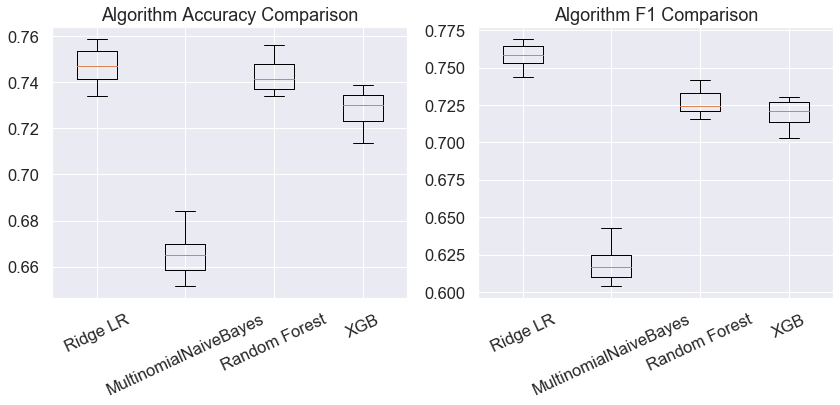

In [115]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(14, 5))

axs[0].boxplot(acc_results)
axs[0].set_title('Algorithm Accuracy Comparison')
axs[0].set_xticklabels(names,rotation=25)

axs[1].boxplot(f1_results)
axs[1].set_title('Algorithm F1 Comparison')
axs[1].set_xticklabels(names,rotation=25)

plt.show()

- Models perform poorly. 

In [118]:
# Try CountVectorizer with Ridge

# initialize count vectorizer
vectorizer = CountVectorizer()

# fit and transform
X_c = vectorizer.fit_transform(str_ingr)

# split train-test, response is cuisine
X_ctrain, X_ctest, y_ctrain, y_ctest = train_test_split(X_c,
                                                    cuisine,
                                                    test_size=0.20,
                                                    random_state=7,
                                                    stratify=cuisine)  

model = LogisticRegression(solver='lbfgs',random_state=7,max_iter=1000,class_weight='balanced', multi_class = 'auto')
cv_acc_result = cross_val_score(model, X_ctrain, y_ctrain, cv=kfold, scoring='accuracy')
cv_f1_result = cross_val_score(model, X_ctrain, y_ctrain, cv=kfold, scoring='f1_weighted')
print("Accuracy = {0:.2f}, f1 = {1:.2f}".format(cv_acc_result.mean(),cv_f1_result.mean()))         

Accuracy = 0.74, f1 = 0.75


- not any better. Tune hyperparameters.

In [125]:
# Grid search to tune Ridge regression hyperparameters
# Keep using Tfidf
C = [0.001,0.01,0.1,1,1.5,2,5,10,100]
for c_val in C:
    model = LogisticRegression(solver='lbfgs',C=c_val,random_state=7,
                               max_iter=1000,class_weight='balanced', multi_class = 'auto')
    cv_acc_result = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    cv_f1_result = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1_weighted')
    print("C = {2:f}: Accuracy = {0:.2f}, f1 = {1:.2f}".format(cv_acc_result.mean(),cv_f1_result.mean(), c_val)) 

C = 0.001000: Accuracy = 0.58, f1 = 0.60
C = 0.010000: Accuracy = 0.62, f1 = 0.63
C = 0.100000: Accuracy = 0.70, f1 = 0.71
C = 1.000000: Accuracy = 0.75, f1 = 0.76
C = 1.500000: Accuracy = 0.75, f1 = 0.76
C = 2.000000: Accuracy = 0.75, f1 = 0.76
C = 5.000000: Accuracy = 0.75, f1 = 0.76
C = 10.000000: Accuracy = 0.75, f1 = 0.76
C = 100.000000: Accuracy = 0.73, f1 = 0.74


In [127]:
# Check classification report and confusion matrix
model = LogisticRegression(solver='lbfgs',C=1,random_state=7,
                               max_iter=1000,class_weight='balanced', multi_class = 'auto')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

   brazilian       0.40      0.62      0.49        93
     british       0.41      0.68      0.52       161
cajun_creole       0.68      0.78      0.73       309
     chinese       0.85      0.79      0.82       535
    filipino       0.54      0.69      0.60       151
      french       0.58      0.64      0.61       529
       greek       0.66      0.79      0.72       235
      indian       0.90      0.84      0.87       601
       irish       0.45      0.62      0.52       133
     italian       0.91      0.75      0.82      1568
    jamaican       0.65      0.87      0.74       105
    japanese       0.79      0.72      0.75       284
      korean       0.74      0.86      0.79       166
     mexican       0.95      0.84      0.89      1288
    moroccan       0.67      0.85      0.75       164
     russian       0.36      0.66      0.46        98
 southern_us       0.80      0.65      0.72       864
     spanish       0.42    

## Ridge regression has 75% accuracy in both training & test sets ==> good generalizability

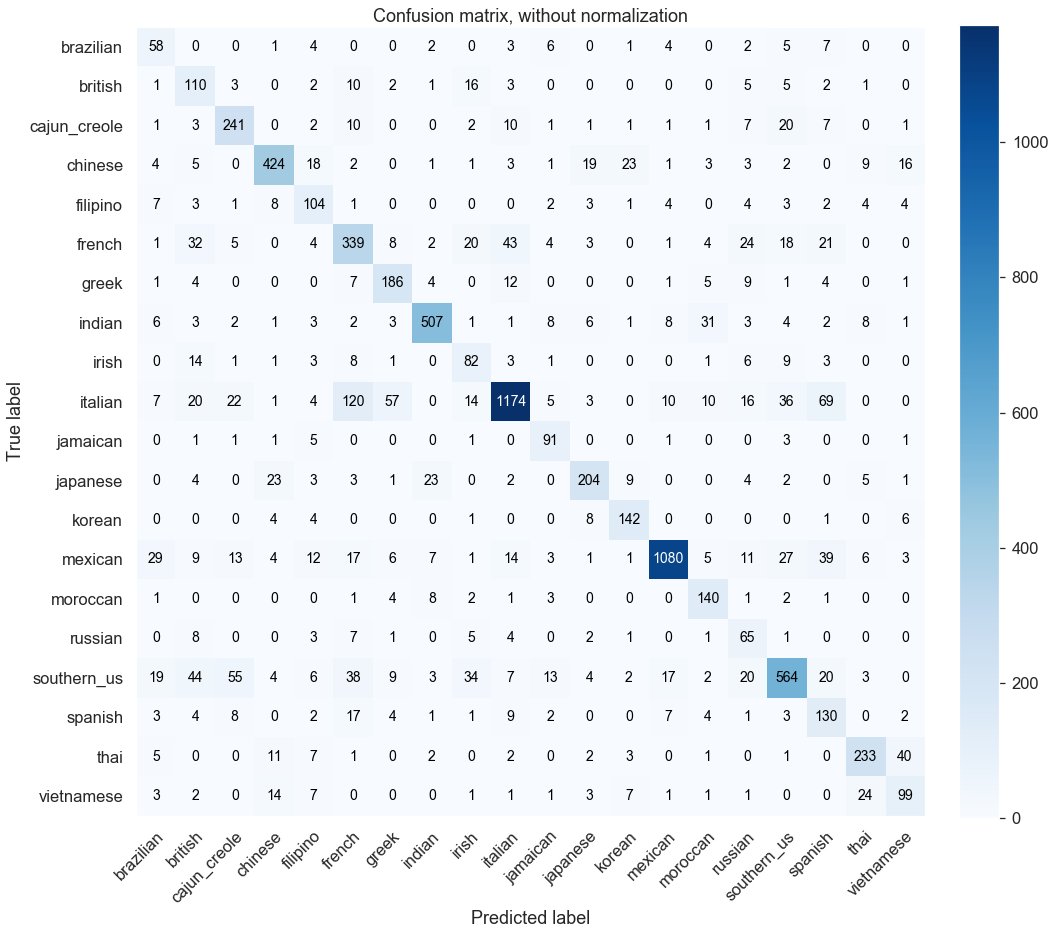

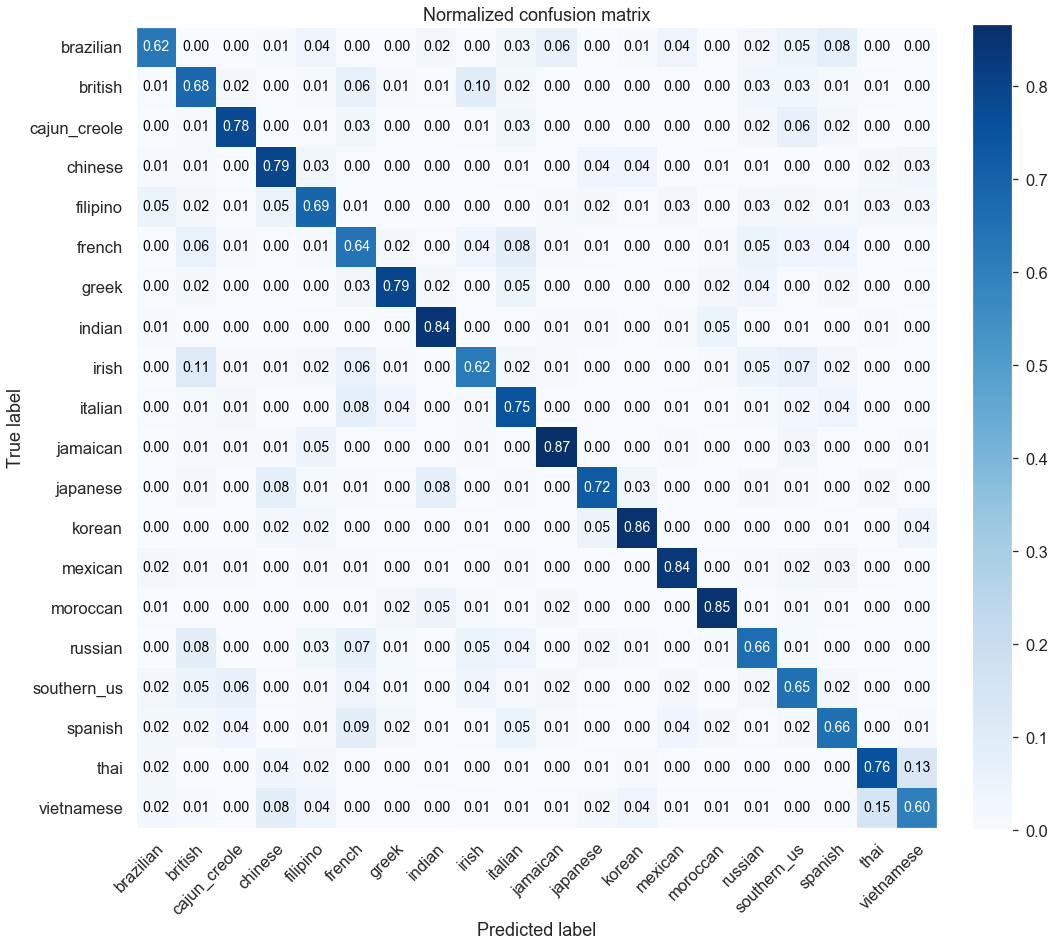

In [156]:
# Plot confusion matrix
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred,normalize=False,title=None,cmap=plt.cm.Blues):   
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(15, 15))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, fraction=0.046, pad=0.04)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label',)
    ax.grid(False)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black", fontsize=14)
    fig.tight_layout()
    return ax


np.set_printoptions(precision=1)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=None,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=None, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

- Mis-classification occurs often when cuisines shares historical origin, e.g. (vietnamese, thai and chinese)(brazilian and spanish)
- Would be helpful to combine some categories in response to the above situation.

### Most frequent ingredients for each cuisine, based on inverse_transformed tfidf vocabulary

In [24]:
model = LogisticRegression(solver='lbfgs',C=1,random_state=7,
                               max_iter=1000,class_weight='balanced', multi_class = 'auto')
model.fit(X_train, y_train)
model.classes_

array(['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino',
       'french', 'greek', 'indian', 'irish', 'italian', 'jamaican',
       'japanese', 'korean', 'mexican', 'moroccan', 'russian',
       'southern_us', 'spanish', 'thai', 'vietnamese'], dtype='<U12')

In [33]:
# iterate through the classes to print out top 5 most frequent ingredients
# Take class subset of the Tfidf matrix and calculate mean Tf-idf for each feature

# List out feature names from Tfidf vocabulary
feature_array = np.array(vectorizer.get_feature_names())

for cuisine_class in model.classes_:
    # boolean vector for selecting rows
    selectrow = [c == cuisine_class for c in cuisine]
    
    # subset the tfidf 2-D array
    sub_tfidf = X.toarray()[selectrow,:]
    
    # calculate mean (axis = 0 for columns)
    # then argsort and return indiced in descending way [::-1]
    sub_sorting = np.argsort(np.mean(sub_tfidf,axis = 0))[::-1]
    
    # top 5 features
    top_5 = feature_array[sub_sorting][:5]
    
    print("="*20)
    print(cuisine_class)
    print(top_5)    

brazilian
['milk' 'cachaca' 'lime' 'coconut' 'pepper']
british
['flour' 'butter' 'sugar' 'milk' 'eggs']
cajun_creole
['pepper' 'seasoning' 'celery' 'bell' 'green']
chinese
['sauce' 'soy' 'sesame' 'oil' 'ginger']
filipino
['sauce' 'soy' 'garlic' 'onions' 'water']
french
['butter' 'sugar' 'large' 'fresh' 'salt']
greek
['feta' 'lemon' 'olive' 'fresh' 'oregano']
indian
['ground' 'cumin' 'masala' 'coriander' 'ginger']
irish
['potatoes' 'baking' 'butter' 'flour' 'salt']
italian
['cheese' 'olive' 'fresh' 'pepper' 'parmesan']
jamaican
['thyme' 'pepper' 'ground' 'allspice' 'salt']
japanese
['soy' 'mirin' 'sauce' 'sesame' 'sake']
korean
['sesame' 'soy' 'sauce' 'oil' 'seeds']
mexican
['cilantro' 'tortillas' 'lime' 'pepper' 'cheese']
moroccan
['ground' 'cinnamon' 'cumin' 'lemon' 'fresh']
russian
['flour' 'eggs' 'sugar' 'salt' 'butter']
southern_us
['butter' 'sugar' 'flour' 'salt' 'baking']
spanish
['olive' 'pepper' 'oil' 'salt' 'red']
thai
['sauce' 'lime' 'fish' 'coconut' 'fresh']
vietnamese
['sau